In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
from optuna.exceptions import ExperimentalWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ExperimentalWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
import numpy as np
import pandas as pd
import time
from tqdm import tqdm
import matplotlib.pyplot as plt


# from pyspark.sql import SparkSession
from replay.utils.session_handler import get_spark_session, State

from replay.models import UCB, Wilson, RandomRec, LinUCB, ThompsonSampling
from replay.experimental.scenarios.movielens_wrapper.replay_offline import OBPOfflinePolicyLearner
from replay.experimental.scenarios.movielens_wrapper.dataset import MovielensBanditDataset
from replay.experimental.scenarios.movielens_wrapper.utils import get_est_rewards_by_reg, bandit_subset
from replay.utils.spark_utils import convert2spark

# from obp.policy import IPWLearner
from obp.ope import (
    OffPolicyEvaluation,
    DirectMethod,
    InverseProbabilityWeighting,
    DoublyRobust,
    SelfNormalizedInverseProbabilityWeighting,
    SelfNormalizedDoublyRobust,
    MarginalizedInverseProbabilityWeighting,
)

'nlp' extra dependecy package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.


In [4]:
spark = State(get_spark_session()).session
spark.sparkContext.setLogLevel('ERROR')

24/09/27 17:09:38 WARN Utils: Your hostname, sudakovcom-MS-7D48 resolves to a loopback address: 127.0.1.1; using 10.255.173.26 instead (on interface enp3s0)
24/09/27 17:09:38 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/27 17:09:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/09/27 17:09:38 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


Lets define OpenBanditDataset class with random policy. For the purpose of demonstration we won't use the whole dataset but only subset of size 10000.

In [5]:
from rs_datasets import MovieLens

data = MovieLens("1m")
data.info()

ratings


,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968



users


,user_id,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117



items


,item_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


Оставим только 300 самых популярных айтемов

In [6]:
logs = data.ratings
logs['cnt'] = 1
logs = logs[['item_id', 'cnt']].groupby(by=["item_id"]).sum()
logs = logs.sort_values(by=['cnt'], ascending=False).reset_index()
# popular_items = logs.iloc[:300]['item_id'].tolist()
popular_items = logs['item_id'].tolist()

In [7]:
data.ratings = data.ratings[data.ratings['item_id'].isin(popular_items)]
print('размер датасета логов после выброса непопулярных айтемов:', data.ratings.shape)

размер датасета логов после выброса непопулярных айтемов: (1000209, 5)


Оставим информацию только о фичах юзеров и айтемов которые остались в логах

In [8]:
data.items = data.items[data.items['item_id'].isin(popular_items)]
users = set(data.ratings['user_id'].tolist())
data.users = data.users[data.users['user_id'].isin(users)]
data.users.shape, data.items.shape

((6040, 5), (3706, 3))

In [9]:
len(data.items['item_id'].unique()), len(data.ratings['item_id'].unique())

(3706, 3706)

In [32]:
dataset = MovielensBanditDataset(data)

27-Sep-24 17:19:29, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
27-Sep-24 17:19:31, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
27-Sep-24 17:19:31, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model


In [40]:
bandit_feedback_train, bandit_feedback_test = dataset.obtain_batch_bandit_feedback(test_size=0.3, is_timeseries_split=True)

print(bandit_feedback_train["n_rounds"])
print(bandit_feedback_test["n_rounds"])

700144
300065


In [45]:
train_log = bandit_feedback_train['log'].toPandas()
train_items = train_log['item_idx'].tolist()
train_pscores = train_log['pscore'].tolist()

test_log = bandit_feedback_test['log'].toPandas()
test_items = test_log['item_idx'].tolist()
test_pscores = test_log['pscore'].tolist()

In [46]:
item2pscore = np.zeros(dataset.n_actions)
for i in range(train_log.shape[0]):
    item2pscore[train_items[i]] = train_pscores[i]
    
for i in range(test_log.shape[0]):
    item2pscore[test_items[i]] = test_pscores[i]

In [47]:
bandit_feedback_train.keys()

dict_keys(['log', 'item_features', 'user_features', 'n_rounds', 'n_actions', 'action', 'position', 'reward', 'pscore', 'context', 'action_context'])

The keys of the dictionary are as follows.
- n_rounds: number of rounds, data size of the logged bandit data;
- n_actions: number of actions $|\mathcal{A}|$;
- action: action variables sampled by the behavior policy;
- position: positions where actions are recommended, there are three positions in the ZOZOTOWN rec interface;
- reward: binary reward variables, click indicators;
- pscore: action choice probabilities by the behavior policy, propensity scores;
- context: context vectors such as user-related features and user-item affinity scores;
- action_context: item-related context vectors

In [48]:
# model_5 = LinTS(1, 1, 'disjoint')
# learner_5 = OBPOfflinePolicyLearner(n_actions=dataset.n_actions,
#                                     replay_model=model_5)
# learner_5.fit(bandit_feedback_train)

In [49]:
#Define replay model
# model_1 = UCB(exploration_coef = 0, sample = True, seed = 123)
# model_1 = UCB(exploration_coef = 0.01, sample = True, seed = 123)
model_2 = LinUCB(eps = -10.0, alpha = 1.0, regr_type = 'disjoint')
# model_3 = RandomRec(seed=42)
# model_4 = ThompsonSampling(sample = True, seed = 123)

#Define learner which connects OBP data format with replay
# learner_1 = OBPOfflinePolicyLearner(n_actions=dataset.n_actions,
#                                     replay_model=model_1) #len_list is the number of predicted items per user
learner_2 = OBPOfflinePolicyLearner(n_actions=dataset.n_actions,
                                    replay_model=model_2) #len_list is the number of predicted items per user
# learner_3 = OBPOfflinePolicyLearner(n_actions=dataset.n_actions,
#                                     replay_model=model_3)
# learner_4 = OBPOfflinePolicyLearner(n_actions=dataset.n_actions,
#                                     replay_model=model_4)

**RePlayOfflinePolicyLearner** has the following methods
- *fit(action, reward, timestamp, context, action_context)*;
- *predict(n_rounds, context)* (context can be None thus n_rounds is **required**);
- *optimize(bandit_feedback, val_size, param_borders, criterion, budget, new_study)*

In [50]:
bandit_feedback_train['log'].toPandas()

,user_idx,item_idx,relevance,timestamp,cnt,pscore
0,3021,366,1,2000-11-22 06:03:07,1,0.000686
1,3021,37,1,2000-11-22 06:03:36,1,0.001913
2,3021,6,1,2000-11-22 06:04:11,1,0.002467
3,3021,278,1,2000-11-22 05:59:35,1,0.000838
4,3021,106,1,2000-11-22 06:02:34,1,0.001388
...,...,...,...,...,...,...
700139,779,858,0,2000-04-26 06:35:41,1,0.000343
700140,779,123,1,2000-04-26 03:21:27,1,0.001193
700141,779,650,1,2000-04-26 03:19:06,1,0.000436
700142,779,945,1,2000-04-26 06:20:48,1,0.000353


In [52]:
#Fit replay model inside our learner
# learner_1.fit(bandit_feedback_train)
learner_2.fit(bandit_feedback_train)
# learner_3.fit(bandit_feedback_train)
# learner_4.fit(bandit_feedback_train)

# Off-policy evaluation

In [20]:
estimated_rewards_by_reg_model = get_est_rewards_by_reg(bandit_feedback_train['n_actions'],
                                                        dataset.len_list,
                                                        bandit_feedback_train,
                                                        bandit_feedback_test)

np.save('estimated_rewards_by_reg_model.npy', estimated_rewards_by_reg_model)

When we get distribution over actions - we can run any evaluation procedure from the OBP. Here we use three estimators
- *IPW*: Average rewards with importance weights
- *DM*: Average predicted rewards using the classifier
- *DR*: Combination of the above methods with zero bias and lower variance

Also, we can construct confidence intervals for each of these methods.

In [21]:
def get_dist(learner):
    all_action_dist = np.zeros((bandit_feedback_test["n_rounds"], bandit_feedback_test["n_actions"], 1))
    if isinstance(learner.replay_model, (LinUCB)):
        log_distinct = bandit_feedback_test['log'].toPandas().drop_duplicates(subset=["user_idx"], keep='first')
        users_all = bandit_feedback_test['log'].toPandas()['user_idx'].tolist()
        batch_size = 10
        num_batchs = log_distinct.shape[0] // batch_size
        for i in tqdm(range(num_batchs+1)):
            j = min((i+1)*batch_size, bandit_feedback_test["n_rounds"])
            if j == i*batch_size:
                break
            log_subset = log_distinct.iloc[i*batch_size: j]
            n_rounds = log_subset.shape[0]
            
            action_dist = learner.predict(n_rounds, convert2spark(log_subset).select('user_idx'))

            users_distinct = log_subset['user_idx'].tolist()

            user2ind = {}
            for i in range(n_rounds):
                user2ind[users_distinct[i]] = i

            for i in range(bandit_feedback_test["n_rounds"]):
                if users_all[i] in users_distinct:
                    all_action_dist[i] = action_dist[user2ind[users_all[i]]]

    else:
        batch_size = 300
        num_batchs = bandit_feedback_test["n_rounds"] // batch_size
        for i in tqdm(range(num_batchs+1)):
            j = min((i+1)*batch_size, bandit_feedback_test["n_rounds"])
            if j == i*batch_size:
                break
            bandit_feedback_subset = bandit_subset([i*batch_size, j], bandit_feedback_test) #The first parameter is a slice of subset [a, b]
            action_dist = learner.predict(bandit_feedback_subset["n_rounds"], bandit_feedback_subset["log"].select('user_idx'))
            all_action_dist[i*batch_size:j] = action_dist
    return all_action_dist

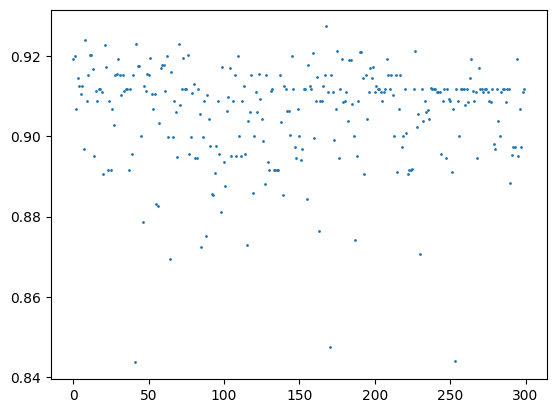

In [22]:
plt.scatter(np.arange(len(estimated_rewards_by_reg_model[0][:, 0])), estimated_rewards_by_reg_model[0][:, 0], s = 1)
plt.show()

In [23]:
#Predict distribution over actions: shape (n_rounds, n_actions)
import time
import warnings
warnings.filterwarnings("ignore")

learner_action_dist_1 = get_dist(learner_1)

# learner_action_dist_2 = get_dist(learner_2)

# learner_action_dist_3 = get_dist(learner_3)

learner_action_dist_4 = get_dist(learner_4)

100%|██████████| 390/390 [01:07<00:00,  5.74it/s]


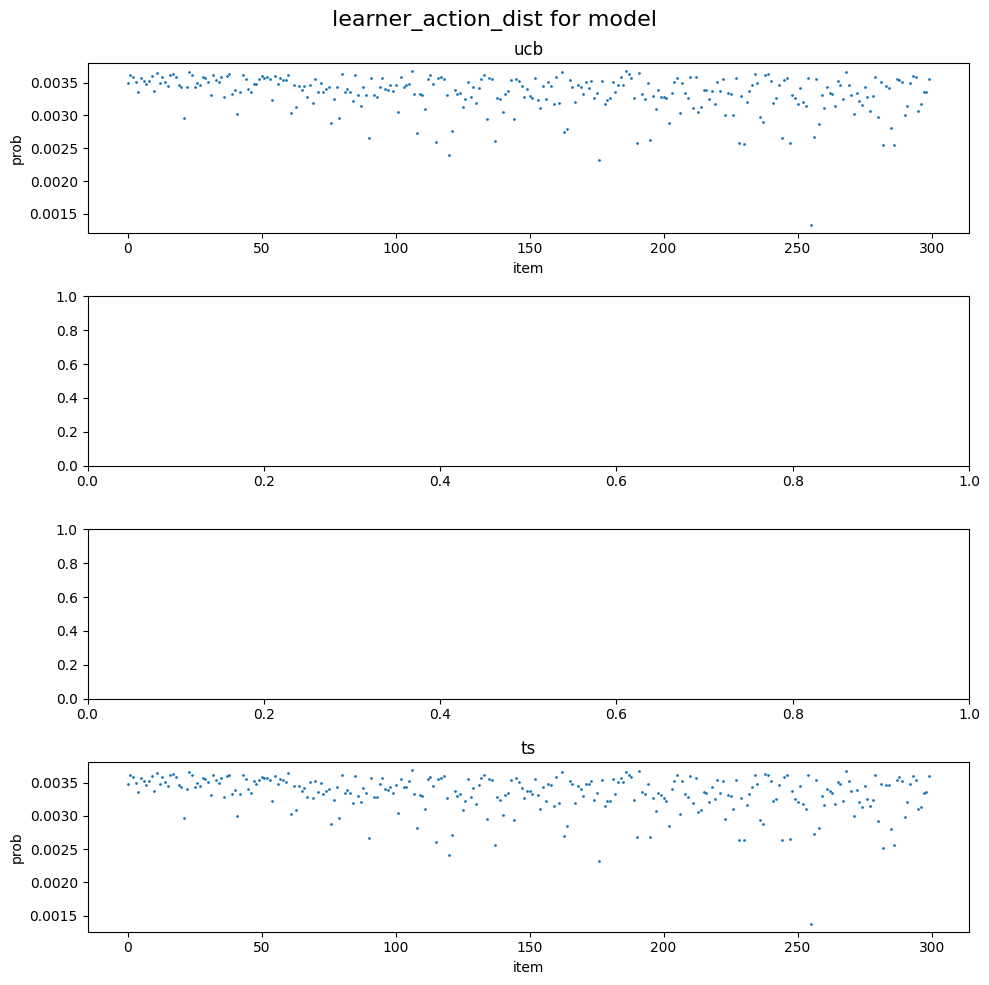

In [24]:
fig, ax = plt.subplots(4, figsize=(10, 10))

ax[0].set_title('ucb')
ax[0].set_xlabel('item')
ax[0].set_ylabel('prob')

ax[0].scatter(np.arange(len(learner_action_dist_1[0][:, 0])), learner_action_dist_1[0][:, 0], s = 1)


# ax[1].set_title('linucb')
# ax[1].set_xlabel('item')
# ax[1].set_ylabel('prob')

# ax[1].scatter(np.arange(len(learner_action_dist_2[0][:, 0])), learner_action_dist_2[0][:, 0], s = 1)


# ax[2].set_title('random')
# ax[2].set_xlabel('item')
# ax[2].set_ylabel('prob')

# ax[2].scatter(np.arange(len(learner_action_dist_3[0][:, 0])), learner_action_dist_3[0][:, 0], s = 1)


ax[3].set_title('ts')
ax[3].set_xlabel('item')
ax[3].set_ylabel('prob')

ax[3].scatter(np.arange(len(learner_action_dist_4[0][:, 0])), learner_action_dist_4[0][:, 0], s = 1)


fig.suptitle("learner_action_dist for model", fontsize=16)
plt.tight_layout()

In [25]:
actions = bandit_feedback_test['action']
pscores = bandit_feedback_test['pscore']
rewards = bandit_feedback_test['reward'][actions]

ips ucb: 1.749560977442756


NameError: name 'ips2' is not defined

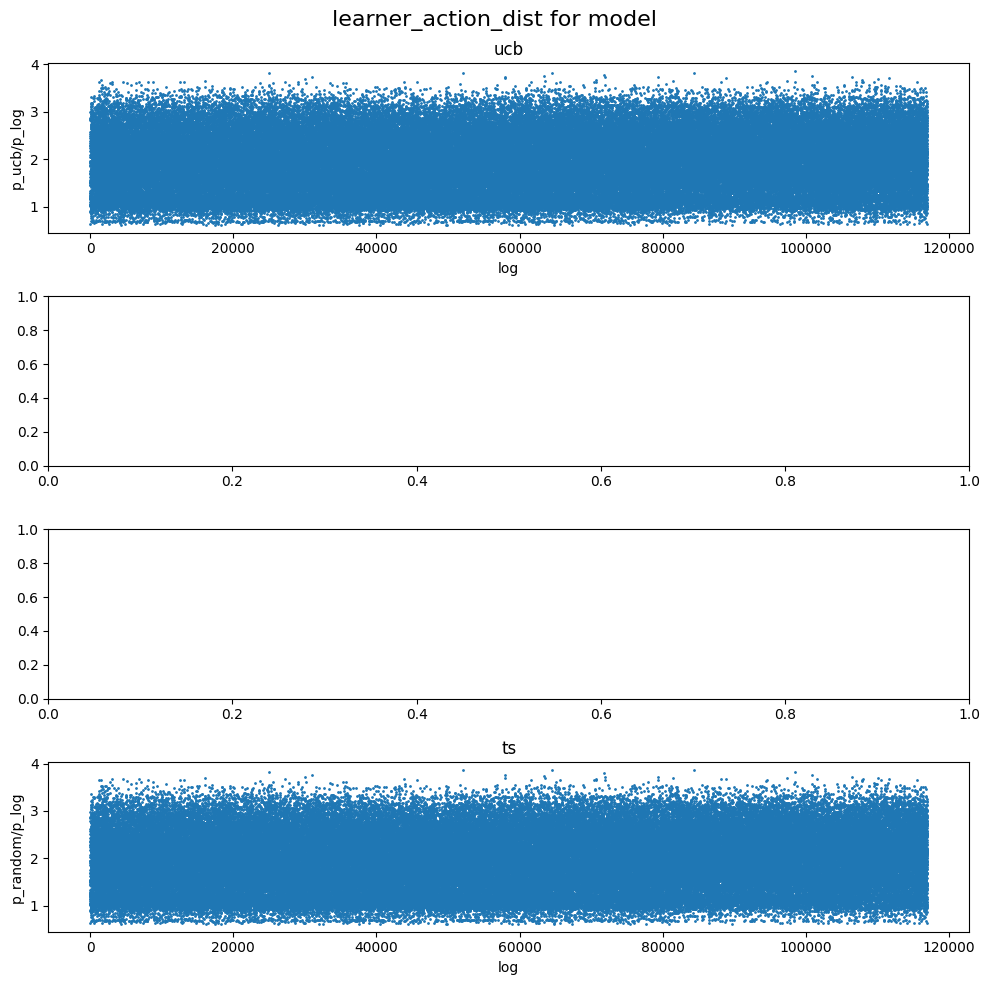

In [26]:
fig, ax = plt.subplots(4, figsize=(10, 10))

ax[0].set_title('ucb')
ax[0].set_xlabel('log')
ax[0].set_ylabel('p_ucb/p_log')

ax[0].scatter(np.arange(actions.size), learner_action_dist_1[np.arange(actions.size), actions, 0]/pscores, s = 1)
ips1 = (rewards * learner_action_dist_1[np.arange(actions.size), actions, 0]/pscores).mean()

# ax[1].set_title('linucb')
# ax[1].set_xlabel('log')
# ax[1].set_ylabel('p_linucb/p_log')

# ax[1].scatter(np.arange(actions.size), learner_action_dist_2[np.arange(actions.size), actions, 0]/pscores, s = 1)
# ips2 = (rewards * learner_action_dist_2[np.arange(actions.size), actions, 0]/pscores).mean()


# ax[2].set_title('random')
# ax[2].set_xlabel('log')
# ax[2].set_ylabel('p_random/p_log')

# ax[2].scatter(np.arange(actions.size), learner_action_dist_3[np.arange(actions.size), actions, 0]/pscores, s = 1)
# ips3 = (rewards * learner_action_dist_3[np.arange(actions.size), actions, 0]/pscores).mean()


ax[3].set_title('ts')
ax[3].set_xlabel('log')
ax[3].set_ylabel('p_random/p_log')

ax[3].scatter(np.arange(actions.size), learner_action_dist_4[np.arange(actions.size), actions, 0]/pscores, s = 1)
ips4 = (rewards * learner_action_dist_4[np.arange(actions.size), actions, 0]/pscores).mean()



fig.suptitle("learner_action_dist for model", fontsize=16)
plt.tight_layout()


print('ips ucb:', ips1)
print('ips linucb:', ips2)
print('ips random:', ips3)
print('ips ts:', ips4)

In [28]:
bandit_feedback_test["n_rounds"]

116921

In [29]:
def run_exp(learner_action_dist):
    Vs = []
    CIs = []

    # for n_size in [50000, 100000, 150000, 200000, 250000, 300000]:
    # for n_size in [20000, 40000, 60000, 80000, 100000, 120000, 140000, 160000, 180000, 2000000, bandit_feedback_test["n_rounds"]]:
    for n_size in [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, bandit_feedback_test["n_rounds"]]:
        start = time.time()
        bandit_feedback_subset = bandit_subset([0, n_size], bandit_feedback_test) #The first parameter is a slice of subset [a, b]

        ope = OffPolicyEvaluation(
            bandit_feedback=bandit_feedback_subset,
            ope_estimators=[InverseProbabilityWeighting(), DirectMethod(), SelfNormalizedDoublyRobust(),
                            SelfNormalizedInverseProbabilityWeighting(),]
        )

        estimated_rewards_by_reg_model_subset = estimated_rewards_by_reg_model[0: n_size, :]
        
        action_dist = learner_action_dist[:n_size, :]
        estimated_policy_value = ope.estimate_policy_values(
            action_dist=action_dist,
            estimated_rewards_by_reg_model=estimated_rewards_by_reg_model_subset,
        )

        estimated_ci = ope.estimate_intervals(
            action_dist=action_dist,
            estimated_rewards_by_reg_model=estimated_rewards_by_reg_model_subset,
            n_bootstrap_samples=100,
            random_state=12345,)
        end = time.time()
        print("n_size =", n_size, "time: ", end-start)
        Vs.append(estimated_policy_value)
        CIs.append(estimated_ci)
    return(Vs, CIs)

In [30]:
Vs_1, CIs_1 = run_exp(learner_action_dist_1)

n_size = 10000 time:  0.1655740737915039
n_size = 20000 time:  0.2964961528778076
n_size = 30000 time:  0.32372188568115234
n_size = 40000 time:  0.5162739753723145
n_size = 50000 time:  0.5665407180786133
n_size = 60000 time:  0.6002407073974609
n_size = 70000 time:  0.9437069892883301
n_size = 80000 time:  0.9801478385925293
n_size = 90000 time:  1.0254321098327637
n_size = 100000 time:  1.1110854148864746
n_size = 116921 time:  1.2077257633209229


In [32]:
Vs_2, CIs_2 = run_exp(learner_action_dist_2)

n_size = 10000 time:  0.15886211395263672
n_size = 20000 time:  0.285783052444458
n_size = 30000 time:  0.3504037857055664
n_size = 40000 time:  0.5257034301757812
n_size = 50000 time:  0.5582253932952881
n_size = 60000 time:  0.6023895740509033
n_size = 70000 time:  0.9442024230957031
n_size = 80000 time:  0.9873383045196533
n_size = 90000 time:  1.048590898513794
n_size = 100000 time:  1.0845222473144531
n_size = 116921 time:  1.1867597103118896


In [33]:
Vs_3, CIs_3 = run_exp(learner_action_dist_3)

n_size = 10000 time:  0.16148757934570312
n_size = 20000 time:  0.2828793525695801
n_size = 30000 time:  0.32167553901672363
n_size = 40000 time:  0.5154335498809814
n_size = 50000 time:  0.5495941638946533
n_size = 60000 time:  0.6010017395019531
n_size = 70000 time:  0.9445204734802246
n_size = 80000 time:  0.9836688041687012
n_size = 90000 time:  1.0256869792938232
n_size = 100000 time:  1.0943634510040283
n_size = 116921 time:  1.1672077178955078


In [31]:
Vs_4, CIs_4 = run_exp(learner_action_dist_4)

n_size = 10000 time:  0.17681217193603516


n_size = 20000 time:  0.2911949157714844
n_size = 30000 time:  0.3320016860961914
n_size = 40000 time:  0.5335545539855957
n_size = 50000 time:  0.5669040679931641
n_size = 60000 time:  0.5993862152099609
n_size = 70000 time:  0.94026780128479
n_size = 80000 time:  0.9891388416290283
n_size = 90000 time:  1.035442590713501
n_size = 100000 time:  1.0973596572875977
n_size = 116921 time:  1.1622068881988525


In [35]:
def plot_disjoint_res(Vs, CIs, model): 
    fig, ax = plt.subplots(4, figsize=(10, 10))

    # x = [5000, 10000, 15000, 20000, 25000, 30000]
    x = [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, bandit_feedback_test["n_rounds"]]
    colors = ['b', 'r', 'g', 'y', 'k']
    i = 0
    for name in ['ipw', 'dm', 'sndr', 'snipw']:
        y_est = [estimated_ci[name]["mean"] for estimated_ci in CIs]
        y_up = [estimated_ci[name]["95.0% CI (upper)"] for estimated_ci in CIs]
        y_low = [estimated_ci[name]["95.0% CI (lower)"] for estimated_ci in CIs]

        ax[i].plot(x, y_est, '-', label=name, color = colors[i])
        ax[i].fill_between(x, y_low, y_up, alpha=0.2, color = colors[i])
        #ax.plot(x, y, 'o', color='tab:brown')
        i=i+1
    fig.suptitle("OPE for " + model, fontsize=16)
    fig.legend()

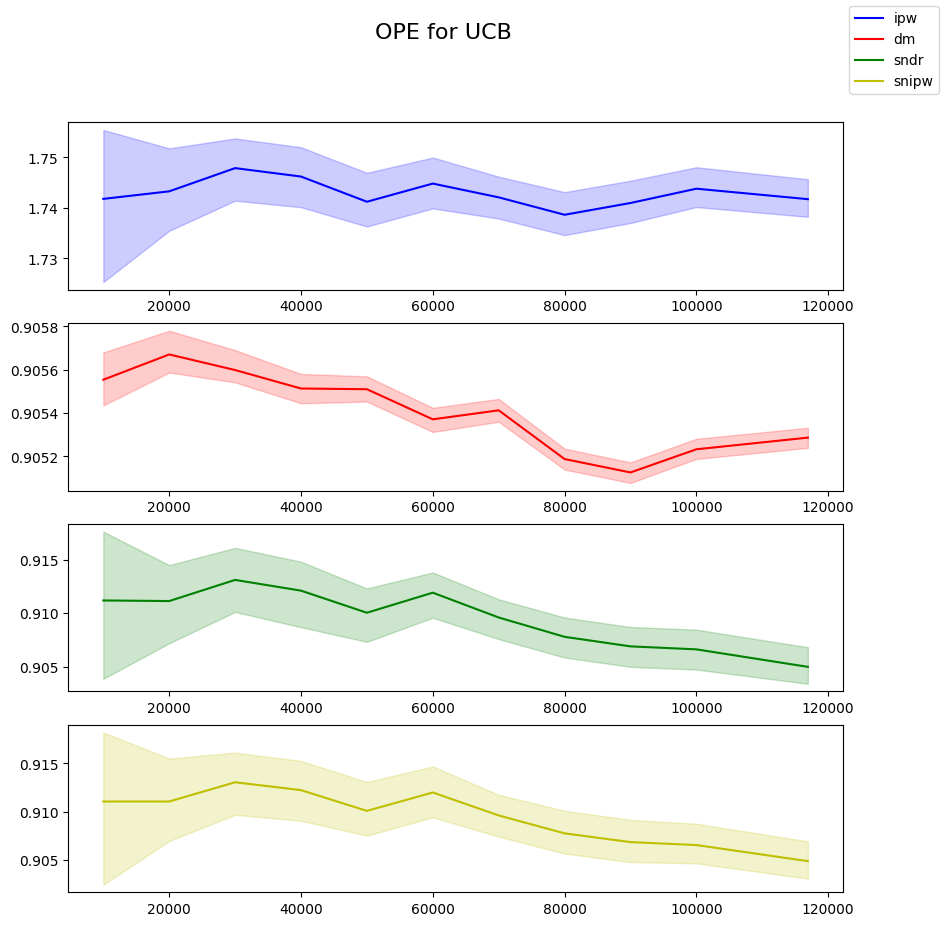

In [36]:
plot_disjoint_res(Vs_1, CIs_1, 'UCB')

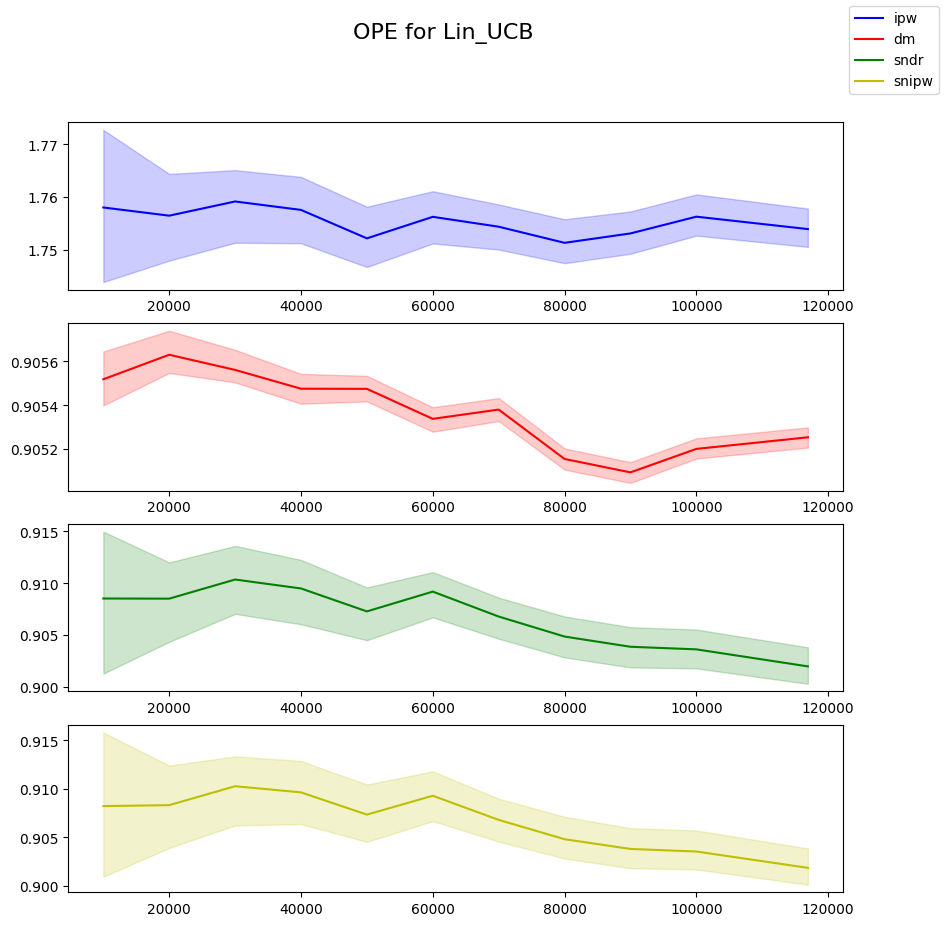

In [37]:
plot_disjoint_res(Vs_2, CIs_2, 'Lin_UCB')

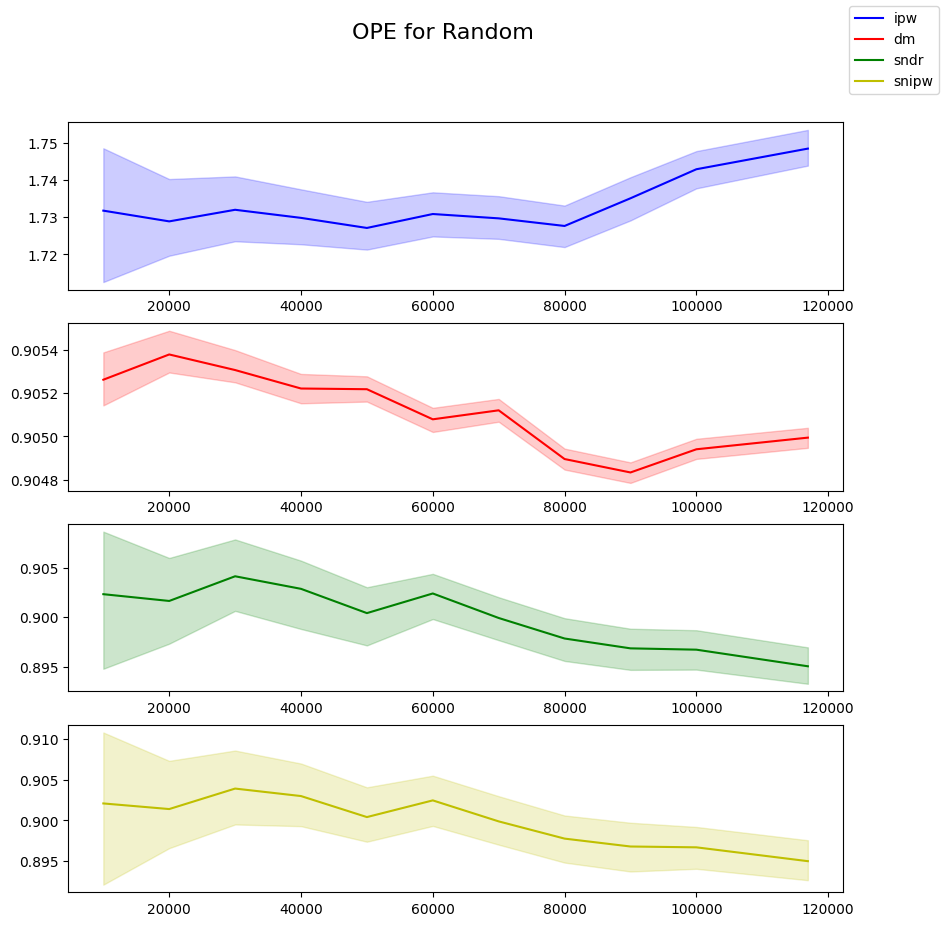

In [38]:
plot_disjoint_res(Vs_3, CIs_3, 'Random')

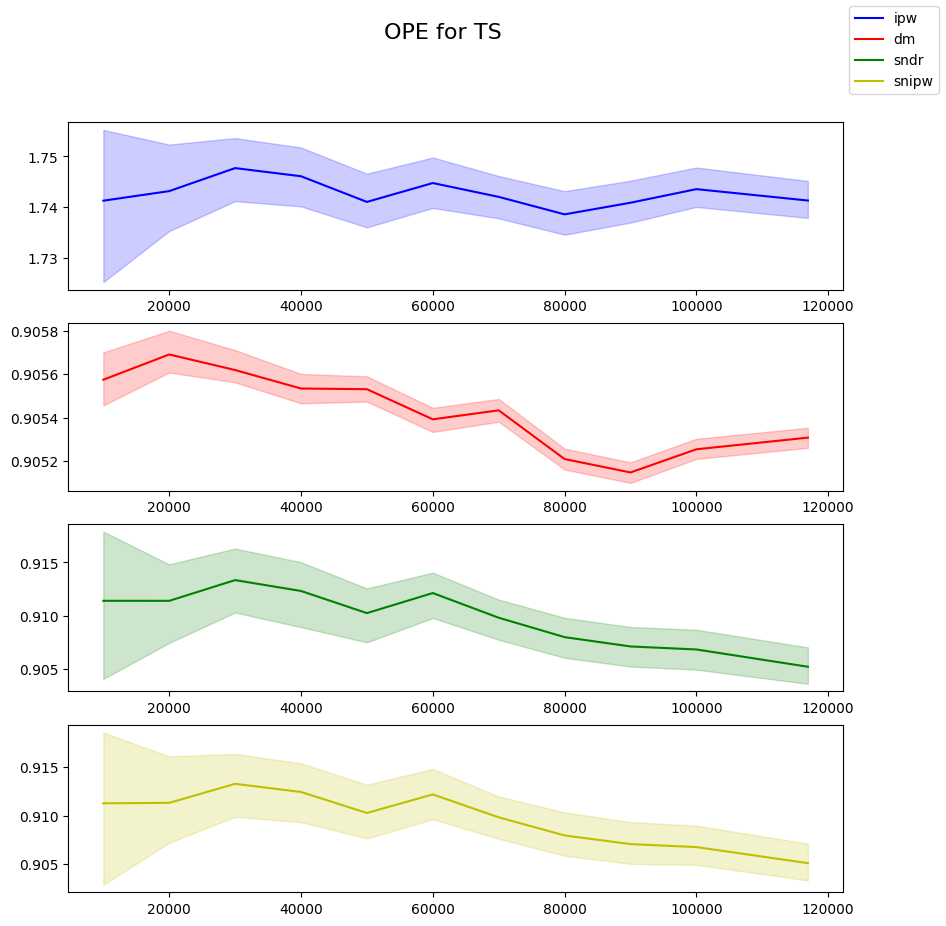

In [39]:
plot_disjoint_res(Vs_4, CIs_4, 'TS')

In [48]:
out_str = f"Scores for UCB true"
for key, val in Vs_1[-1].items():
    out_str += f" {key} : {(1e3 * val):.3f},"
out_str = out_str[:-1]
print(out_str)

Scores for UCB true ipw : 1741.513, dm : 905.286, sndr : 904.884, snipw : 904.771


In [49]:
out_str = f"Scores for Lin_UCB true"
for key, val in Vs_2[-1].items():
    out_str += f" {key} : {(1e3 * val):.3f},"
out_str = out_str[:-1]
print(out_str)

Scores for Lin_UCB true ipw : 1753.737, dm : 905.253, sndr : 901.869, snipw : 901.760


In [50]:
out_str = f"Scores for random true"
for key, val in Vs_3[-1].items():
    out_str += f" {key} : {(1e3 * val):.3f},"
out_str = out_str[:-1]
print(out_str)

Scores for random true ipw : 1748.198, dm : 904.993, sndr : 894.928, snipw : 894.821


In [51]:
out_str = f"Scores for ts true"
for key, val in Vs_4[-1].items():
    out_str += f" {key} : {(1e3 * val):.3f},"
out_str = out_str[:-1]
print(out_str)

Scores for ts true ipw : 1741.086, dm : 905.306, sndr : 905.118, snipw : 905.005


In [52]:
print("USB")
print(Vs_1[-1])
print("Lin USB")
print(Vs_2[-1])
print("Random")
print(Vs_3[-1])
print("TS")
print(Vs_4[-1])

USB
{'ipw': 1.741513378164084, 'dm': 0.9052855338260706, 'sndr': 0.9048836639966071, 'snipw': 0.9047707949441275}
Lin USB
{'ipw': 1.7537365748981686, 'dm': 0.9052527882012282, 'sndr': 0.9018694139358382, 'snipw': 0.9017599003191309}
Random
{'ipw': 1.7481978127512288, 'dm': 0.9049933519658112, 'sndr': 0.8949276888777743, 'snipw': 0.8948208597499274}
TS
{'ipw': 1.7410858692744844, 'dm': 0.9053063597788371, 'sndr': 0.9051182091921555, 'snipw': 0.9050051248816999}


In [53]:
print("Estimated confidence intervals UCB:")
print(pd.DataFrame(CIs_1[-1]).to_string())
print("Estimated confidence intervals Lin UCB:")
print(pd.DataFrame(CIs_2[-1]).to_string())
print("Estimated confidence intervals Random:")
print(pd.DataFrame(CIs_3[-1]).to_string())
print("Estimated confidence intervals TS:")
print(pd.DataFrame(CIs_4[-1]).to_string())

Estimated confidence intervals UCB:
                       ipw        dm      sndr     snipw
mean              1.741701  0.905287  0.904991  0.904868
95.0% CI (lower)  1.738201  0.905240  0.903408  0.903050
95.0% CI (upper)  1.745649  0.905332  0.906825  0.906919
Estimated confidence intervals Lin UCB:
                       ipw        dm      sndr     snipw
mean              1.753940  0.905254  0.901976  0.901865
95.0% CI (lower)  1.750568  0.905207  0.900297  0.900131
95.0% CI (upper)  1.757834  0.905299  0.903820  0.903867
Estimated confidence intervals Random:
                       ipw        dm      sndr     snipw
mean              1.748461  0.904995  0.895036  0.894956
95.0% CI (lower)  1.743879  0.904947  0.893266  0.892610
95.0% CI (upper)  1.753500  0.905040  0.896947  0.897535
Estimated confidence intervals TS:
                       ipw        dm      sndr     snipw
mean              1.741282  0.905308  0.905226  0.905107
95.0% CI (lower)  1.737860  0.905261  0.903630  0.90

In [32]:
def plot_res_two_politics(CIs_p1, CIs_p2, model_p1, model_p2):
    fig, ax = plt.subplots(4, figsize=(15, 10))
    # x = [5000, 10000, 15000, 20000, 25000, 30000]
    x = [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, bandit_feedback_test["n_rounds"]]
    colors = ['b', 'r', 'g', 'y', 'k']
    i=0
    for name in ['ipw', 'dm', 'sndr', 'snipw']:
        y_est = [estimated_ci[name]["mean"] for estimated_ci in CIs_p1]
        y_up = [estimated_ci[name]["95.0% CI (upper)"] for estimated_ci in CIs_p1]
        y_low = [estimated_ci[name]["95.0% CI (lower)"] for estimated_ci in CIs_p1]

        ax[i].plot(x, y_est, '-', label=model_p1+"_"+name, color = colors[0])
        ax[i].fill_between(x, y_low, y_up, alpha=0.2, color = colors[0])
        
        y_est = [estimated_ci[name]["mean"] for estimated_ci in CIs_p2]
        y_up = [estimated_ci[name]["95.0% CI (upper)"] for estimated_ci in CIs_p2]
        y_low = [estimated_ci[name]["95.0% CI (lower)"] for estimated_ci in CIs_p2]

        ax[i].plot(x, y_est, '-', label=model_p2+"_"+name, color = colors[1])
        ax[i].fill_between(x, y_low, y_up, alpha=0.2, color = colors[1])
        ax[i].set_title(name)
        
        i = i+1
    fig.suptitle("OPE for " + model_p1 + " and " + model_p2, fontsize=16)
    fig.legend()

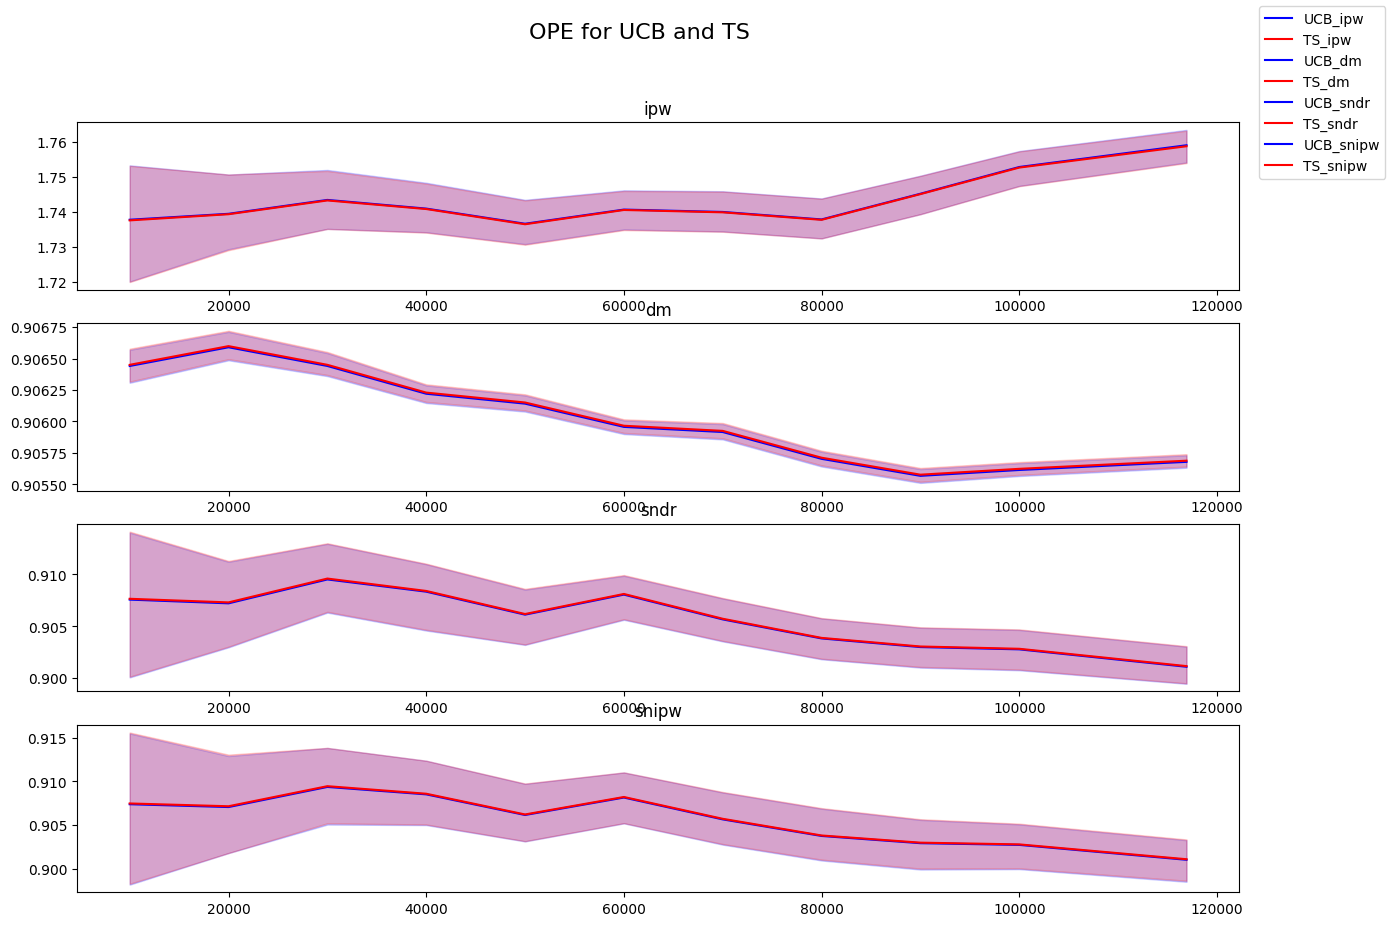

In [33]:
plot_res_two_politics(CIs_1, CIs_4, "UCB", "TS")

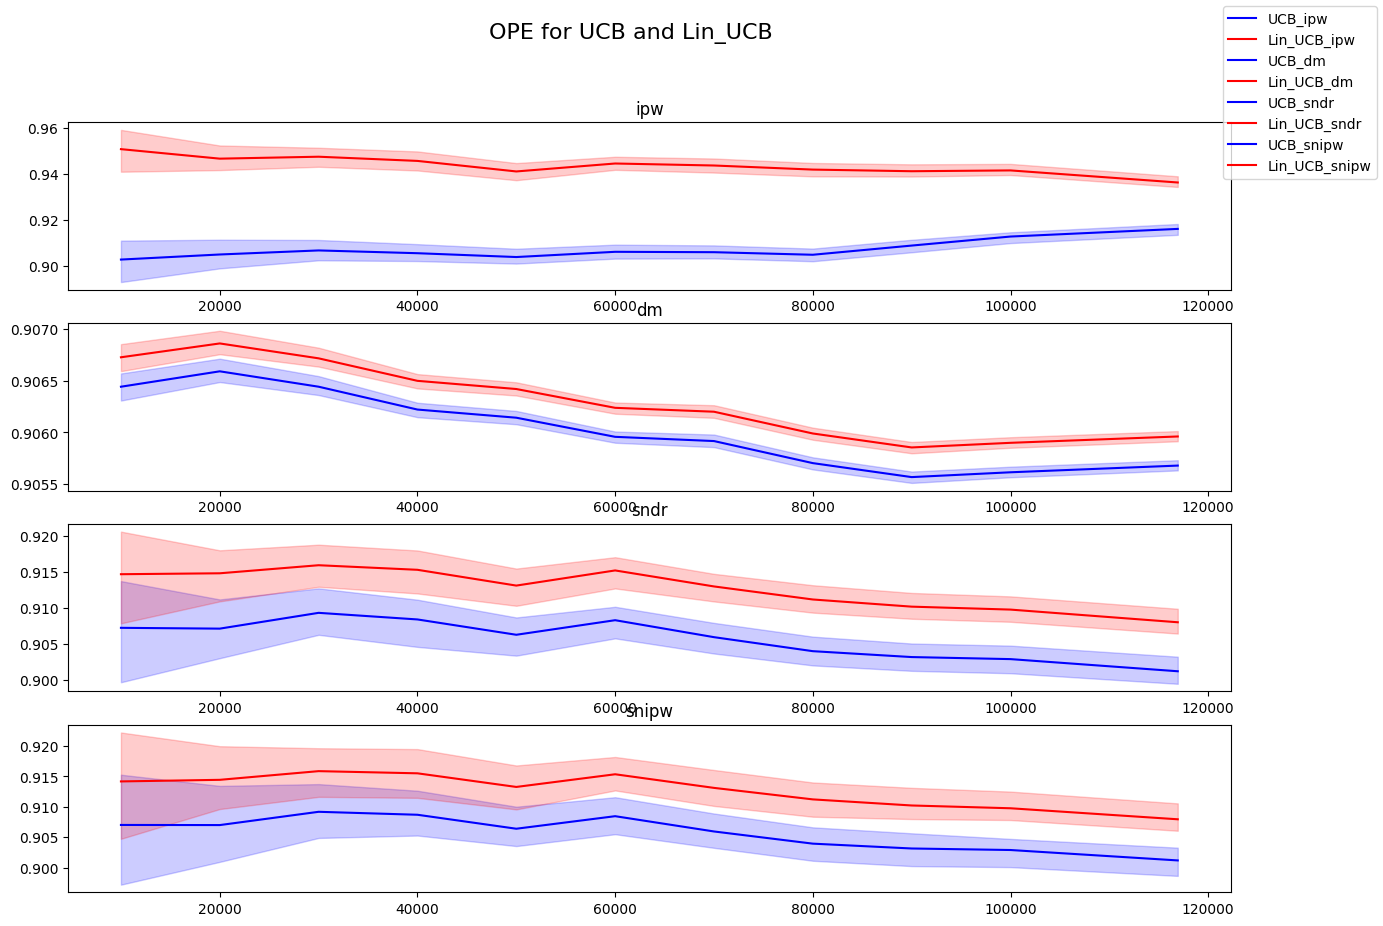

In [42]:
plot_res_two_politics(CIs_1, CIs_2, "UCB", "Lin_UCB")

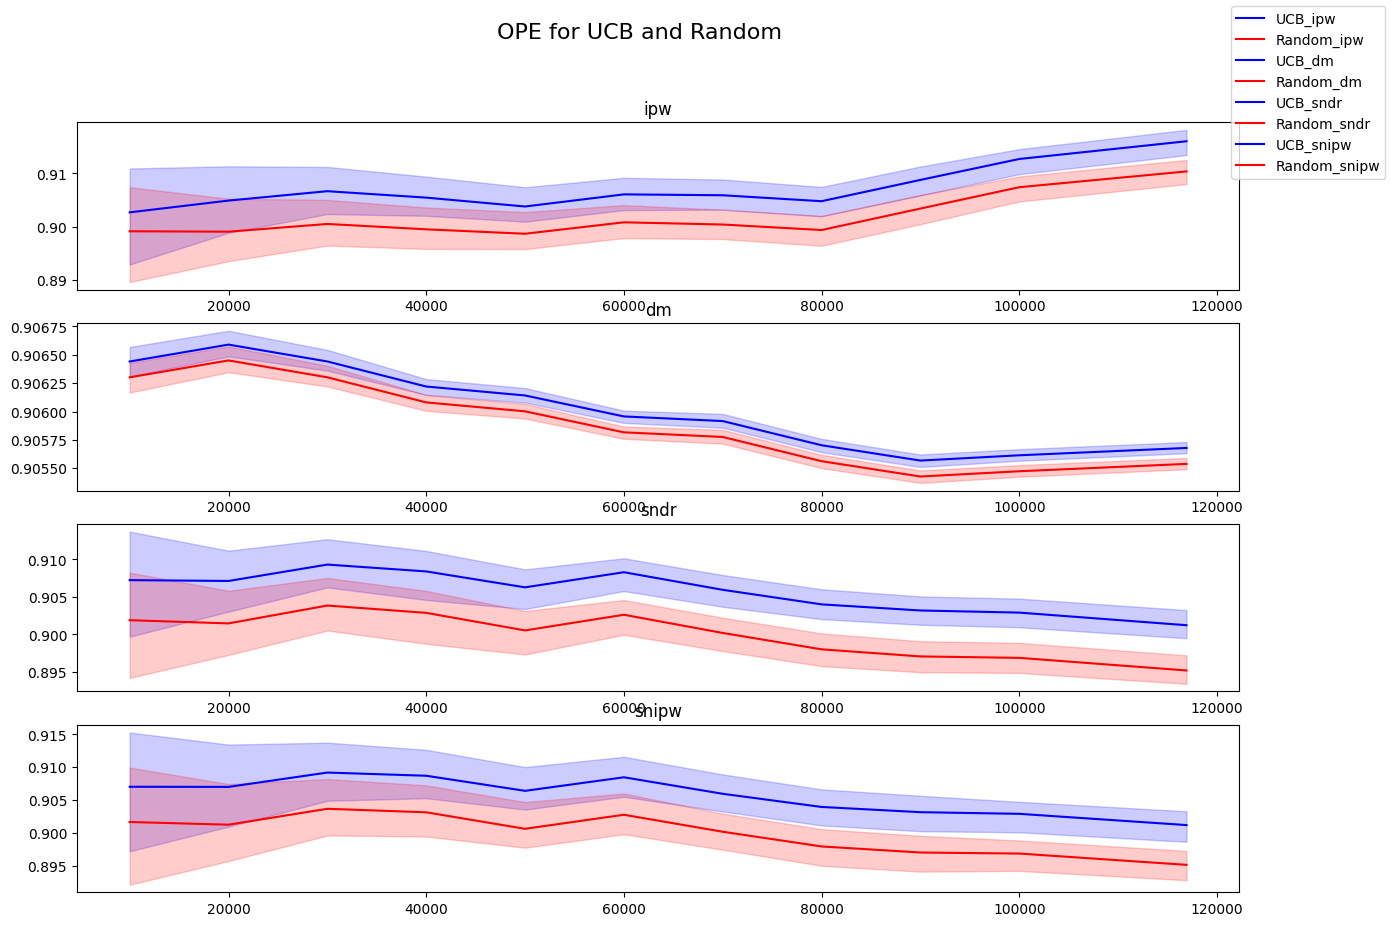

In [43]:
plot_res_two_politics(CIs_1, CIs_3, "UCB", "Random")

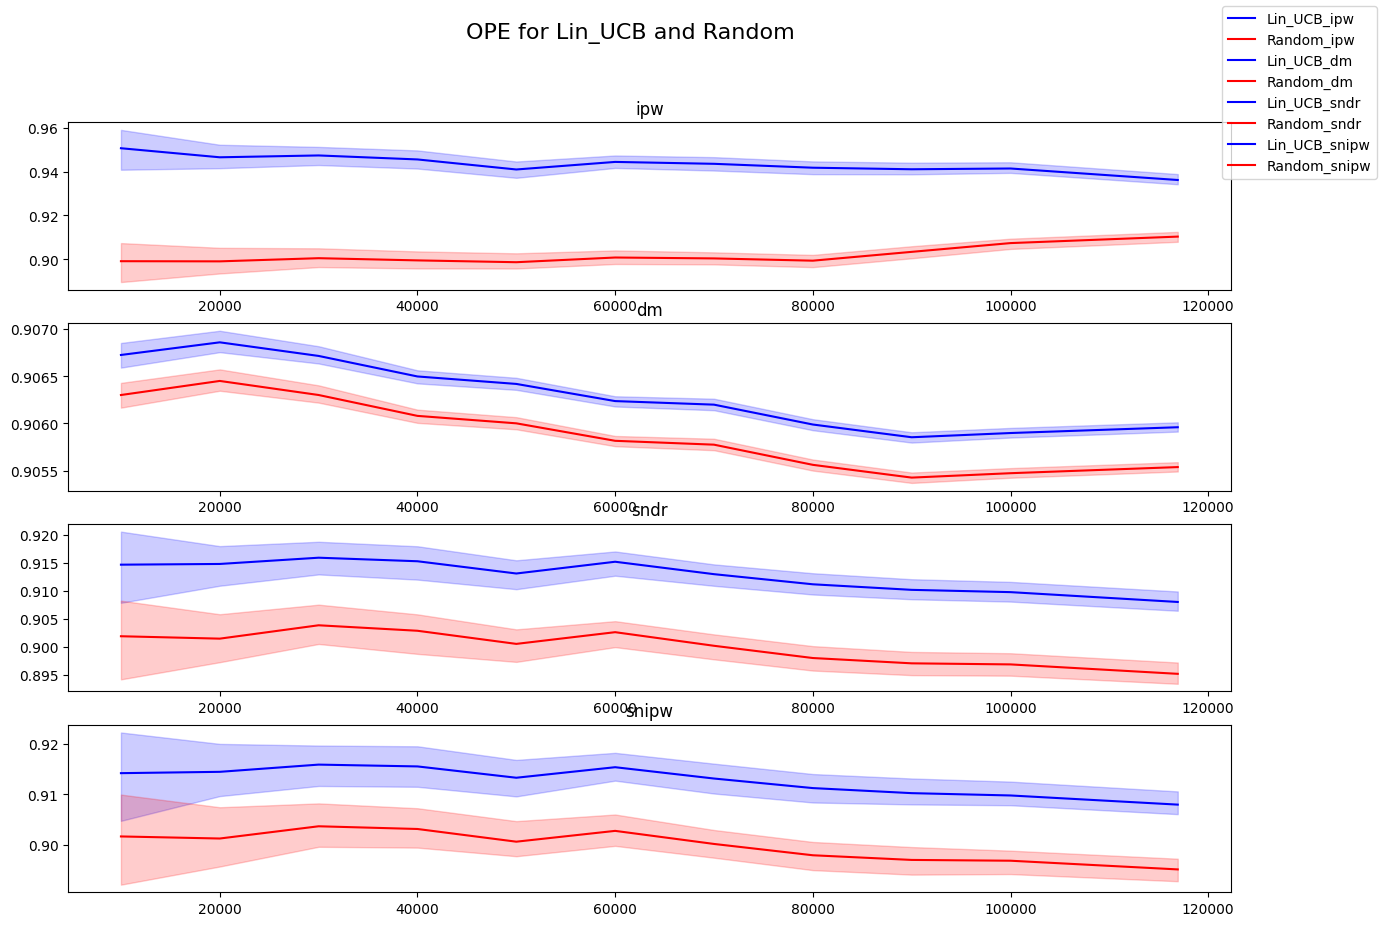

In [44]:
plot_res_two_politics(CIs_2, CIs_3, "Lin_UCB", "Random")

In [45]:
def plot_join_res(Vs, CIs, model):
    fig, ax = plt.subplots(figsize=(10, 10))
    # x = [5000, 10000, 15000, 20000, 25000, 30000]
    x = [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, bandit_feedback_test["n_rounds"]]
    colors = ['b', 'r', 'g', 'y', 'k']
    i = 0
    for name in ['ipw','dm', 'sndr', 'snipw']:
        y_est = [estimated_ci[name]["mean"] for estimated_ci in CIs]
        y_up = [estimated_ci[name]["95.0% CI (upper)"] for estimated_ci in CIs]
        y_low = [estimated_ci[name]["95.0% CI (lower)"] for estimated_ci in CIs]

        ax.plot(x, y_est, '-', label=name, color = colors[i])
        ax.fill_between(x, y_low, y_up, alpha=0.2, color = colors[i])
        #ax.plot(x, y, 'o', color='tab:brown')
        i=i+1
    fig.suptitle("OPE for " + model, fontsize=16)
    fig.legend()

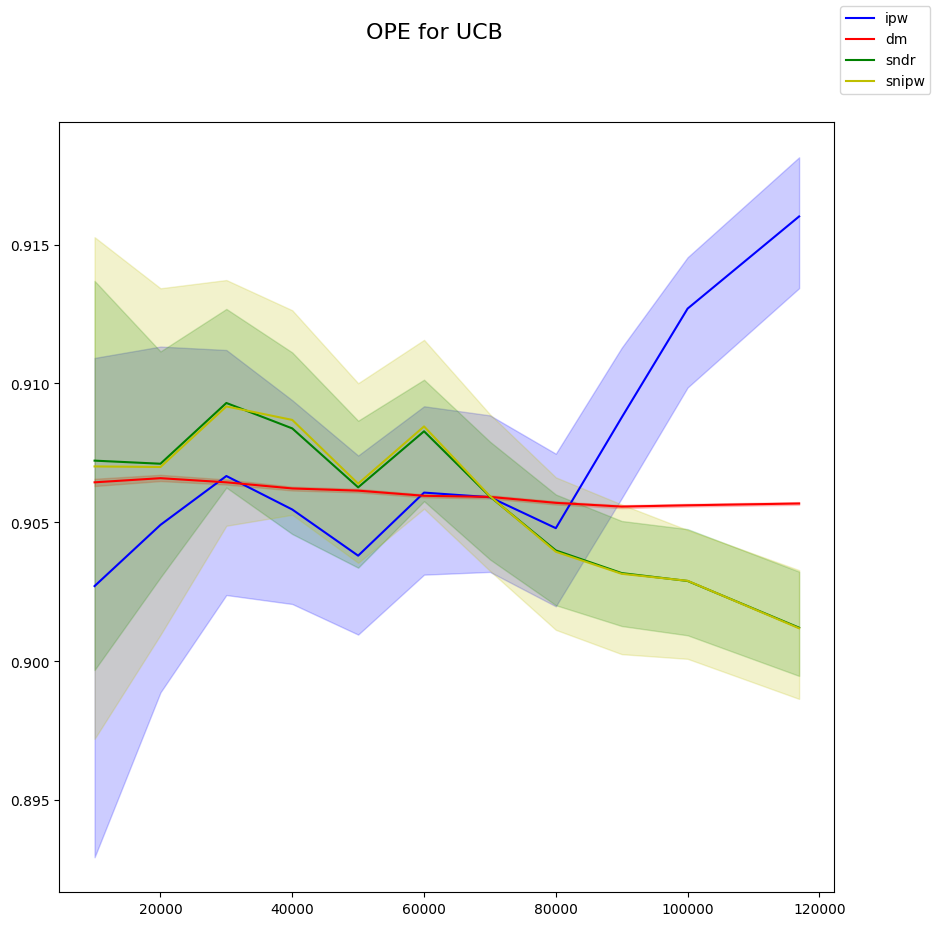

In [46]:
plot_join_res(Vs_1, CIs_1, 'UCB')

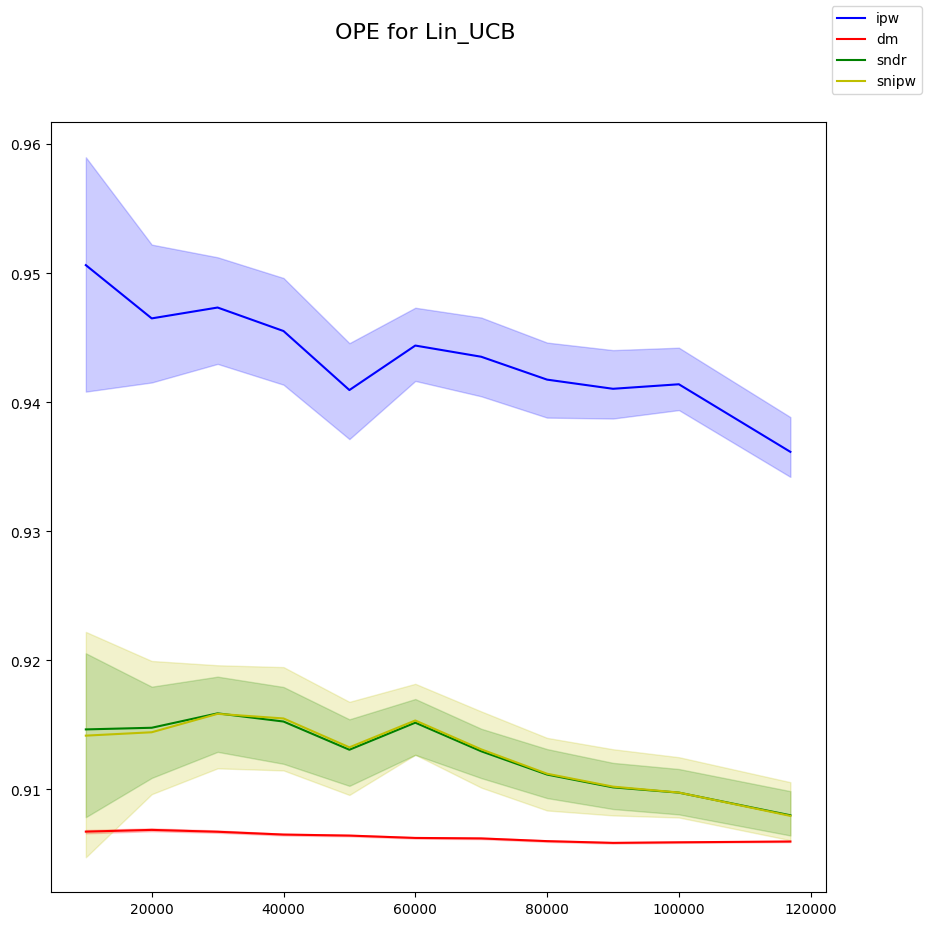

In [47]:
plot_join_res(Vs_2, CIs_2, 'Lin_UCB')

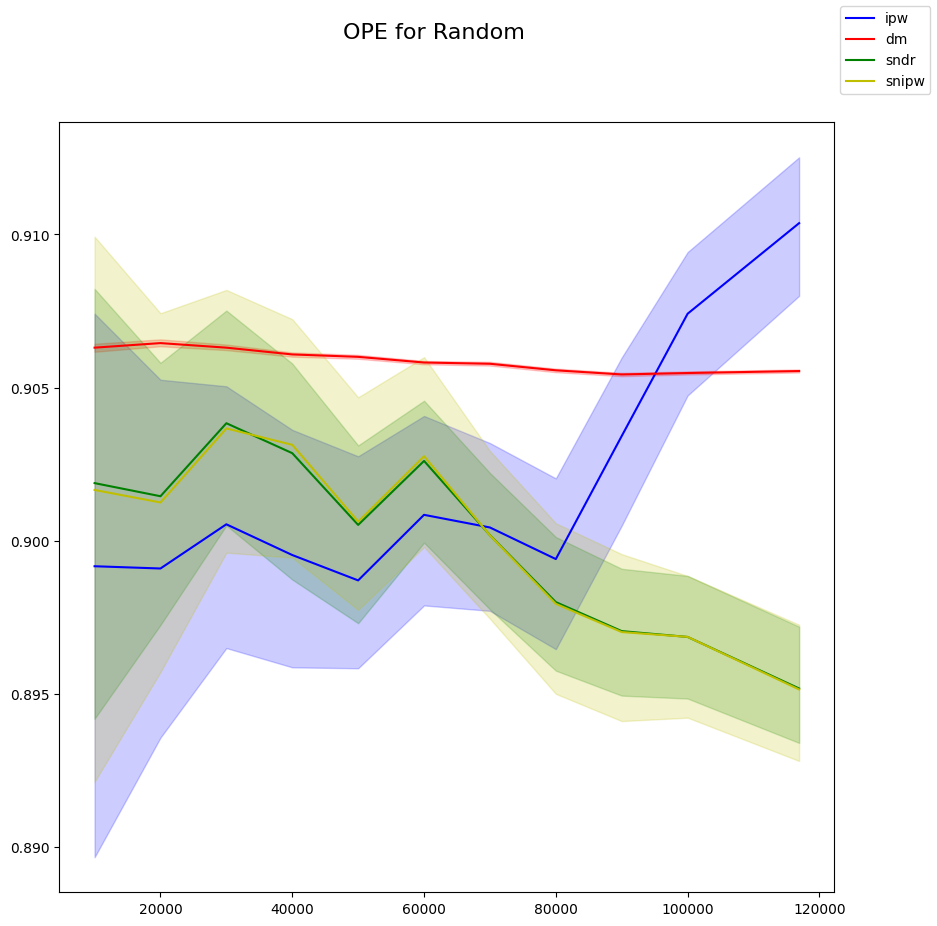

In [48]:
plot_join_res(Vs_3, CIs_3, 'Random')

# Metrics evaluation

In [40]:
import warnings
warnings.filterwarnings("ignore")

In [41]:
len(bandit_feedback_test['log'].toPandas()['user_idx'].unique()), len(data.ratings['user_id'].unique())

(2329, 6039)

In [42]:
print("Ucb")
print(learner_1.predict_and_evaluate(bandit_feedback_test, 1))

print("Lin_ucb")
print(learner_2.predict_and_evaluate(bandit_feedback_test, 1))

print("Random")
print(learner_3.predict_and_evaluate(bandit_feedback_test, 1))

print("TS")
print(learner_4.predict_and_evaluate(bandit_feedback_test, 1))

Ucb


100%|██████████| 233/233 [00:41<00:00,  5.61it/s]


{'hr@1': 0.4670400689358035, 'mrr@1': 0.4670400689358035, 'ndcg@1': 0.4670400689358035, 'cov@1': 0.15666666666666668}
Lin_ucb


100%|██████████| 233/233 [00:19<00:00, 11.99it/s]


{'hr@1': 0.4635932787591555, 'mrr@1': 0.4635932787591555, 'ndcg@1': 0.4635932787591555, 'cov@1': 0.17333333333333334}
Random


100%|██████████| 233/233 [00:40<00:00,  5.77it/s]


{'hr@1': 0.16975441619991383, 'mrr@1': 0.16975441619991383, 'ndcg@1': 0.16975441619991383, 'cov@1': 1.0}
TS


100%|██████████| 233/233 [00:42<00:00,  5.42it/s]

{'hr@1': 0.4670400689358035, 'mrr@1': 0.4670400689358035, 'ndcg@1': 0.4670400689358035, 'cov@1': 0.15666666666666668}


In [43]:
print("Ucb")
print(learner_1.predict_and_evaluate(bandit_feedback_test, 3))

print("Lin_ucb")
print(learner_2.predict_and_evaluate(bandit_feedback_test, 3))

print("Random")
print(learner_3.predict_and_evaluate(bandit_feedback_test, 3))

print("TS")
print(learner_4.predict_and_evaluate(bandit_feedback_test, 3))

Ucb


100%|██████████| 233/233 [00:40<00:00,  5.76it/s]


{'hr@3': 0.6691081430417923, 'mrr@3': 0.5593853224184977, 'ndcg@3': 0.42623738641492426, 'cov@3': 0.32}
Lin_ucb


100%|██████████| 233/233 [00:19<00:00, 12.17it/s]


{'hr@3': 0.6734166307626023, 'mrr@3': 0.557733735458854, 'ndcg@3': 0.4250842998115051, 'cov@3': 0.36}
Random


100%|██████████| 233/233 [00:40<00:00,  5.82it/s]


{'hr@3': 0.36665230504093066, 'mrr@3': 0.25448800804251037, 'ndcg@3': 0.16937171661658873, 'cov@3': 1.0}
TS


100%|██████████| 233/233 [00:42<00:00,  5.45it/s]

{'hr@3': 0.6691081430417923, 'mrr@3': 0.5593853224184977, 'ndcg@3': 0.42603519825205366, 'cov@3': 0.31333333333333335}


In [44]:
print("Ucb")
print(learner_1.predict_and_evaluate(bandit_feedback_test, 10))

print("Lin_ucb")
print(learner_2.predict_and_evaluate(bandit_feedback_test, 10))

print("Random")
print(learner_3.predict_and_evaluate(bandit_feedback_test, 10))

print("TS")
print(learner_4.predict_and_evaluate(bandit_feedback_test, 10))

Ucb


100%|██████████| 233/233 [00:40<00:00,  5.79it/s]


{'hr@10': 0.8272296423955192, 'mrr@10': 0.5879740191351566, 'ndcg@10': 0.38112698318466653, 'cov@10': 0.68}
Lin_ucb


100%|██████████| 233/233 [00:19<00:00, 12.17it/s]


{'hr@10': 0.8358466178371392, 'mrr@10': 0.5867667877146551, 'ndcg@10': 0.3856533089891888, 'cov@10': 0.76}
Random


100%|██████████| 233/233 [00:39<00:00,  5.86it/s]


{'hr@10': 0.6484274019819044, 'mrr@10': 0.30237565225716884, 'ndcg@10': 0.17028315188375556, 'cov@10': 1.0}
TS


100%|██████████| 233/233 [00:42<00:00,  5.49it/s]

{'hr@10': 0.8259370960792761, 'mrr@10': 0.5877028579635215, 'ndcg@10': 0.3812850139415, 'cov@10': 0.6766666666666666}


In [45]:
print("Ucb")
print(learner_1.predict_and_evaluate_new(bandit_feedback_test, 1))

print("Lin_ucb")
print(learner_2.predict_and_evaluate_new(bandit_feedback_test, 1))

print("Random")
print(learner_3.predict_and_evaluate_new(bandit_feedback_test, 1))

print("TS")
print(learner_4.predict_and_evaluate_new(bandit_feedback_test, 1))

Ucb


100%|██████████| 233/233 [00:40<00:00,  5.81it/s]


{'hr@1': 0.020682141249444126, 'mrr@1': 0.020682141249444126, 'ndcg@1': 0.020682141249444126, 'cov@1': 0.25}
Lin_ucb


100%|██████████| 233/233 [00:19<00:00, 12.17it/s]


{'hr@1': 0.019958585255325147, 'mrr@1': 0.019958585255325147, 'ndcg@1': 0.019958585255325147, 'cov@1': 0.27}
Random


100%|██████████| 233/233 [00:39<00:00,  5.87it/s]


{'hr@1': 0.0043709069575707474, 'mrr@1': 0.0043709069575707474, 'ndcg@1': 0.0043709069575707474, 'cov@1': 1.0}
TS


100%|██████████| 233/233 [00:42<00:00,  5.48it/s]


{'hr@1': 0.020687658417850925, 'mrr@1': 0.020687658417850925, 'ndcg@1': 0.020687658417850925, 'cov@1': 0.25333333333333335}


In [46]:
print("Ucb")
print(learner_1.predict_and_evaluate_new(bandit_feedback_test, 3))

print("Lin_ucb")
print(learner_2.predict_and_evaluate_new(bandit_feedback_test, 3))

print("Random")
print(learner_3.predict_and_evaluate_new(bandit_feedback_test, 3))

print("TS")
print(learner_4.predict_and_evaluate_new(bandit_feedback_test, 3))

Ucb


 18%|█▊        | 43/233 [00:07<00:33,  5.75it/s]

100%|██████████| 233/233 [00:40<00:00,  5.80it/s]


{'hr@3': 0.04723949705491287, 'mrr@3': 0.03213922261349987, 'ndcg@3': 0.03600696008780316, 'cov@3': 0.41333333333333333}
Lin_ucb


100%|██████████| 233/233 [00:19<00:00, 12.16it/s]


{'hr@3': 0.046275618509300086, 'mrr@3': 0.03101021418906793, 'ndcg@3': 0.034907658842111826, 'cov@3': 0.49}
Random


100%|██████████| 233/233 [00:39<00:00,  5.87it/s]


{'hr@3': 0.013633635997973178, 'mrr@3': 0.0082072626841534, 'ndcg@3': 0.009590496475817317, 'cov@3': 1.0}
TS


100%|██████████| 233/233 [00:42<00:00,  5.48it/s]


{'hr@3': 0.04717611884409081, 'mrr@3': 0.03211832379208503, 'ndcg@3': 0.035975318642418666, 'cov@3': 0.4166666666666667}


In [47]:
print("Ucb")
print(learner_1.predict_and_evaluate_new(bandit_feedback_test, 10))

print("Lin_ucb")
print(learner_2.predict_and_evaluate_new(bandit_feedback_test, 10))

print("Random")
print(learner_3.predict_and_evaluate_new(bandit_feedback_test, 10))

print("TS")
print(learner_4.predict_and_evaluate_new(bandit_feedback_test, 10))

Ucb


100%|██████████| 233/233 [00:40<00:00,  5.78it/s]


{'hr@10': 0.11779749136119258, 'mrr@10': 0.0431832143547206, 'ndcg@10': 0.06032948987767, 'cov@10': 0.7866666666666666}
Lin_ucb


100%|██████████| 233/233 [00:19<00:00, 12.15it/s]


{'hr@10': 0.1204479967073282, 'mrr@10': 0.0428501784602406, 'ndcg@10': 0.060691285061326414, 'cov@10': 0.8666666666666667}
Random


100%|██████████| 233/233 [00:39<00:00,  5.87it/s]


{'hr@10': 0.04604200880048093, 'mrr@10': 0.013301001439690215, 'ndcg@10': 0.020783585281145423, 'cov@10': 1.0}
TS


100%|██████████| 233/233 [00:42<00:00,  5.46it/s]


{'hr@10': 0.11788482726928337, 'mrr@10': 0.04317580346465341, 'ndcg@10': 0.060340854454522044, 'cov@10': 0.7933333333333333}


In [57]:
assert 1 == 0

AssertionError: 

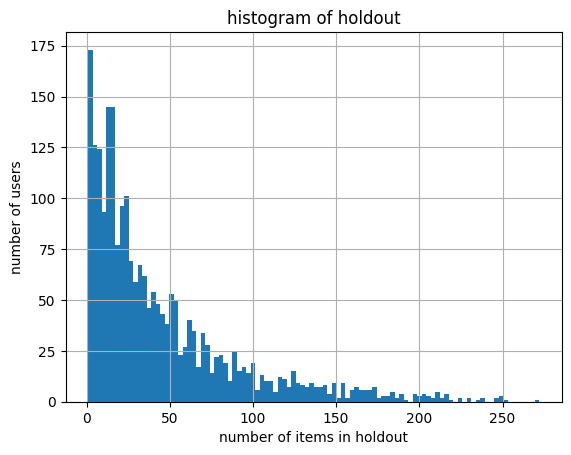

In [85]:
plt.hist(holdout_actions.sum(axis = 1), bins = 100)
plt.grid()
plt.title('histogram of holdout')
plt.xlabel('number of items in holdout')
plt.ylabel('number of users')
plt.show()

In [69]:
p1 = 1 - ((300 - holdout_actions.sum(axis = 1))/300)**1

p3 = 1 - ((300 - holdout_actions.sum(axis = 1))/300)**3

p10 = 1 - ((300 - holdout_actions.sum(axis = 1))/300)**10

print('hr@1:', np.mean(p1), 'hr@2:',np.mean(p3), 'hr@3:',np.mean(p10))

hr@1: 0.1515539279046388 hr@2: 0.3337076625815821 hr@3: 0.6060468370009982
